      tamb  mrt  relhum       pvapor      utci  utci_SMA
0      7.2  0.0      90  1016.874385  6.923862       NaN
1      7.2  2.1      90  1016.874385  2.904746       NaN
2      6.7  2.1      89   982.540856  2.478674       NaN
3      6.1  1.5      93   942.683386  3.614657       NaN
4      4.4  3.1      97   837.334239 -2.128458       NaN
...    ...  ...     ...          ...       ...       ...
8755  13.3  3.1      90  1528.573341  5.965766  7.370378
8756  12.2  1.5      93  1422.402604  8.215982  7.412252
8757  10.6  2.1      96  1279.502450  5.817765  7.423049
8758  10.6  2.1     100  1279.502450  5.921346  7.304015
8759  11.1  1.5      97  1322.743480  7.472728  7.335124

[8760 rows x 6 columns]


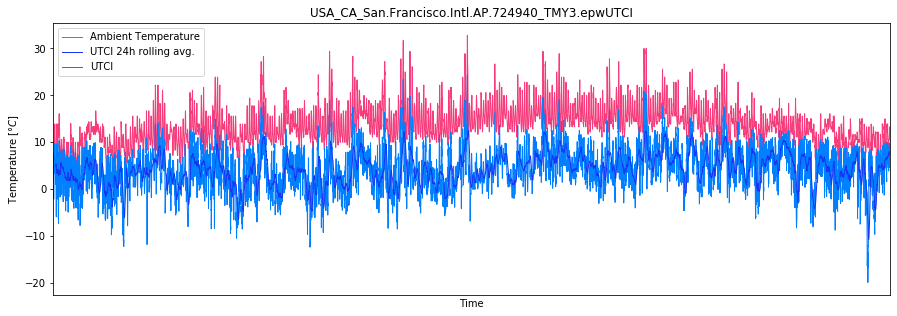

In [13]:
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
import pandas as pd
import os
import UTCI
from pathlib import Path, PureWindowsPath
import epw
from epw import epw
import re
import math

#Get current working directory

epwPath = PureWindowsPath(r"USA_CA_San.Francisco.Intl.AP.724940_TMY3.epw")


def wind(epwPath):
    a=epw()
    a.read(epwPath)
    df=a.dataframe  # this is pandas dataframe
    windvel = df['Wind Speed']
    winddir = df['Wind Direction']

    return winddir, windvel

windvel = wind(epwPath) [1]
winddir = wind(epwPath) [0]

cwd = os.getcwd()

loadPath = Path(cwd)
  
def getepw(epwPath):
    a=epw()
    a.read(epwPath)
    df=a.dataframe  # this is pandas dataframe
    tamb = df['Dry Bulb Temperature']
    windvel = df['Wind Speed']
    relhum = df['Relative Humidity']
    pvapor = df['Dry Bulb Temperature'].apply(lambda x: UTCI.saturated_vapour_pressure(x))
    precipitation = df['Liquid Precipitation Depth']
    
    return tamb  , windvel, relhum, pvapor, precipitation
    
SanFran=getepw(epwPath) 

#cols = [ 'tamb', 'mrt' , 'relhum', 'pvapor']

tamb = pd.Series(SanFran[0])
mrt = pd.Series(SanFran[1])
relhum = pd.Series(SanFran[2])
pvapor = pd.Series(SanFran[3])
precipitation = pd.Series(SanFran[4])


utci = pd.Series(UTCI.utci_numpy(tamb,mrt,windvel,relhum), name='utci')
df1_ = pd.concat([tamb,mrt, relhum, pvapor, utci], axis=1, keys=[ 'tamb', 'mrt' , 'relhum', 'pvapor', 'utci'])
df1_['utci_SMA'] = df1_['utci'].rolling(window=24).mean()


print(df1_)

# Select time

#start_time = '2019-10-17 06:00:00-04:00'
#end_time = '2019-10-17 19:00:00-04:00'

#df1_ = df1.loc[start_time:end_time]


#df1.index

# Print Headers
#print(df1.columns.values)


# Resize figure
custom_figsize=(15,5)

# Change lineweights
lineweights = 1

#Colors, RGB

blueish = (0/255, 127/255, 255/255)
magenta = (247/255, 60/255, 124/255)
teal = (23/255, 142/255, 146/255)
orange = "orange"
dark = '#1735F5'

# Plot two dataframes into one plot
ax = df1_.plot(y=['tamb'],lw = lineweights, figsize=custom_figsize,color=magenta)
df1_.plot(y=['utci_SMA'],lw = lineweights, figsize=custom_figsize,color=dark,ax=ax, zorder = 5)
df1_.plot(y=['utci'],lw = lineweights, figsize=custom_figsize,color=blueish,ax=ax)
# Subset Time Series By Dates Python Using Pandas
#https://www.earthdatascience.org/courses/earth-analytics-python/use-time-series-data-in-python/subset-time-series-data-python/


# Legend
ax.legend([
"Ambient Temperature","UTCI 24h rolling avg.","UTCI"
],loc='upper left', frameon=True)


# Fix xticks

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every minute
hours = mdates.HourLocator()  # every minute
minutes = mdates.MinuteLocator()  # every minute

days_fmt = mdates.DateFormatter('%d')
hours_fmt = mdates.DateFormatter('%H:00')

# format the ticks
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(hours_fmt)
ax.xaxis.set_minor_locator(hours)

#Labels
plt.ylabel('Temperature $[°C]$')
plt.xlabel("Time")
     
# Title
title = str(epwPath)+ "UTCI"

ax.set_title(title)

def windows_filename(s):
    s = str(s).strip().replace(' ', '_')
    return re.sub(r'(?u)[^-\w.]', '', s)

def plot_graph(plt,start_time = "", variable = ""):
    plt.savefig(title+'_' + variable+ '.pdf')

# Save PDF
plot_graph(plt)